# HW Caplets

In [1]:
import numpy as np
import enum 
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.integrate as integrate

In [2]:
# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

In [7]:
def GeneratePathsHWEuler(NoOfPaths, NoOfSteps, T, P0T, lambd, eta):   
    # time-step needed for differentiation
    dt = 0.0001
    # Instantaneous forward rate
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    # theta of HW model
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))      
    
    # Initiate Paths
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps + 1])
    R = np.zeros([NoOfPaths, NoOfSteps + 1])
    R[:,0] = r0
    time = np.zeros([NoOfSteps+1])
        
    dt = T / float(NoOfSteps)
    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])
            
        W[:,i+1] = W[:,i] + np.power(dt, 0.5)*Z[:,i]
        R[:,i+1] = R[:,i] + lambd*(theta(time[i]) - R[:,i]) * dt + eta* (W[:,i+1]-W[:,i])
        time[i+1] = time[i] +dt
        
    # Outputs
    paths = {"time":time,"R":R}
    return paths

In [3]:
def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))

    return theta
    
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)
    
    # Here theta can take T2 - zGrid as parameter because HW_theta return a function theta(t)
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

# Affinity of HW ZCB
def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    B_r = HW_B(lambd,eta,T1,T2)
    A_r = HW_A(lambd,eta,P0T,T1,T2)
    
    return np.exp(A_r + B_r *rT1)

In [4]:
# Parameter for pricing
def HW_r_0(P0T,lambd,eta):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    return r0

def HW_Mu_FrwdMeasure(P0T,lambd,eta,T):
    # time-step needed for differentiation
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    # Initial interest rate is a forward rate at time t->0
    r0 = f0T(0.00001)
    theta = HW_theta(lambd,eta,P0T)
    zGrid = np.linspace(0.0,T,500)
    
    theta_hat = lambda t,T:  theta(t) + eta*eta / lambd * 1.0/lambd * (np.exp(-lambd*(T-t))-1.0)
    
    temp = lambda z: theta_hat(z,T) * np.exp(-lambd*(T-z))
    
    r_mean = r0*np.exp(-lambd*T) + lambd * integrate.trapz(temp(zGrid),zGrid)
    
    return r_mean

def HWVar_r(lambd,eta,T):
    return eta*eta/(2.0*lambd) * (1.0-np.exp(-2.0*lambd *T))

def HWDensity(P0T,lambd,eta,T):
    r_mean = HWMean_r(P0T,lambd,eta,T)
    r_var = HWVar_r(lambd,eta,T)
    return lambda x: st.norm.pdf(x,r_mean,np.sqrt(r_var))

In [11]:
# Pricing function
def HW_CapletFloorletPrice(CP,N,K,lambd,eta,P0T,T1,T2):
    if CP == OptionType.CALL:
        # Adjusted from l(t,T) to P(t, T)
        # Changed formula l(t, T) = 1/tau * (1 - P(t,T)) / (P(t, T))
        # =>
        N_new = N * (1.0 + (T2-T1)*K)
        K_new = 1.0 + (T2-T1)*K
        caplet = N_new*HW_ZCB_CallPutPrice(OptionType.PUT,1.0/K_new,lambd,eta,P0T,T1,T2)
        value = caplet
    elif CP == OptionType.PUT:
        N_new = N * (1.0 + (T2-T1)*K)
        K_new = 1.0 + (T2-T1)*K
        floorlet = N_new*HW_ZCB_CallPutPrice(OptionType.CALL,1.0/K_new,lambd,eta,P0T,T1,T2)
        value = floorlet
    return value
    
def HW_ZCB_CallPutPrice(CP,K,lambd,eta,P0T,T1,T2):
    B_r = HW_B(lambd,eta,T1,T2)
    A_r = HW_A(lambd,eta,P0T,T1,T2)
    
    mu_r = HW_Mu_FrwdMeasure(P0T,lambd,eta,T1)
    v_r =  np.sqrt(HWVar_r(lambd,eta,T1))
    
    K_hat = K * np.exp(-A_r)
    
    a = (np.log(K_hat) - B_r*mu_r)/(B_r*v_r)
    
    d1 = a - B_r*v_r
    d2 = d1 +  B_r*v_r
    
    term1 = np.exp(0.5* B_r*B_r*v_r*v_r + B_r*mu_r)*st.norm.cdf(d1) - K_hat * st.norm.cdf(d2)    
    value =P0T(T1) * np.exp(A_r) * term1 
    
    if CP == OptionType.CALL:
        return value
    elif CP==OptionType.PUT:
        return value - P0T(T2) + K*P0T(T1)

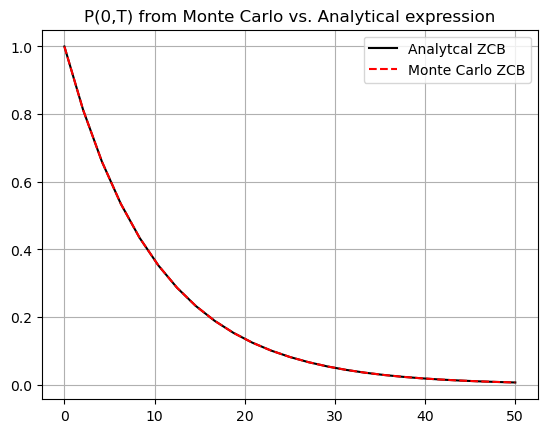

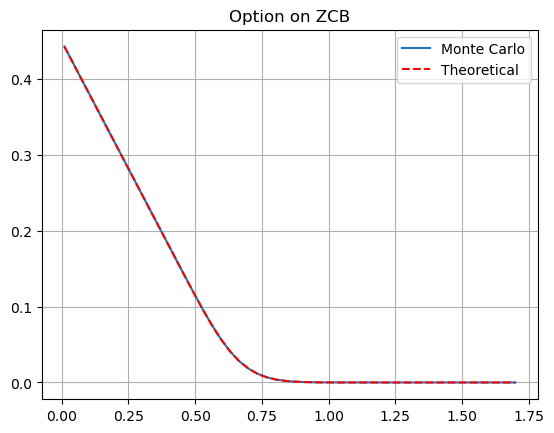

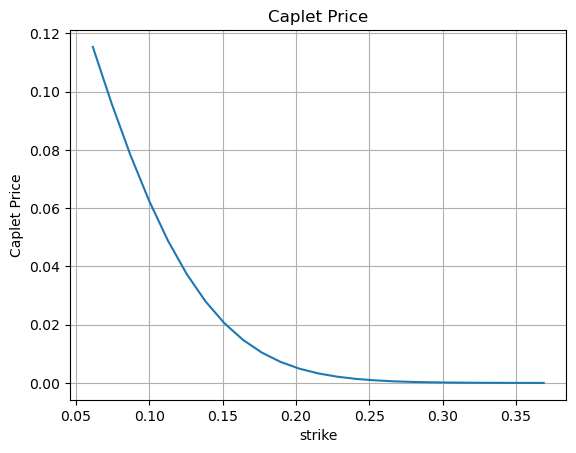

In [13]:
def mainCalculation():
    CP = OptionType.CALL
    NoOfPaths = 20000
    NoOfSteps = 1000
        
    lambd     = 0.02
    eta       = 0.02
    
    # We define a ZCB curve (obtained from the market)
    # A simplified data instead of using market data for interpolator
    P0T = lambda T: np.exp(-0.1*T)#np.exp(-0.03*T*T-0.1*T)
    r0 = HW_r_0(P0T,lambd,eta)
    
    # In this experiment we compare ZCB from the Market and Analytical expression
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)
    
    Exact = np.zeros([N,1])
    Proxy= np.zeros ([N,1])
    for i,Ti in enumerate(Tgrid):
        # Analytical HW ZCB
        Proxy[i] = HW_ZCB(lambd,eta,P0T,0.0,Ti,r0)
        # Market price of ZCB
        Exact[i] = P0T(Ti)
        
    plt.figure(1)
    plt.grid()
    plt.plot(Tgrid,Exact,'-k')
    plt.plot(Tgrid,Proxy,'--r')
    plt.legend(["Analytcal ZCB","Monte Carlo ZCB"])
    plt.title('P(0,T) from Monte Carlo vs. Analytical expression')

    # In this experiment we compare Monte Carlo results for 
    # Option on ZCB
    T1 = 4.0 # maturity of option
    T2 = 8.0 # maturity of ZCB
    
    paths= GeneratePathsHWEuler(NoOfPaths,NoOfSteps,T1 ,P0T, lambd, eta)
    r = paths["R"]
    timeGrid = paths["time"]
    dt = timeGrid[1]- timeGrid[0]
    
    # Here we compare the price of an option on a ZCB from Monte Carlo and Analytical expression    
    M_t = np.zeros([NoOfPaths,NoOfSteps])
    # this part we can include in GeneratePathsHWEuler() function
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,:-1])*dt)
    
    # Vector of strike price for option on ZCB
    KVec = np.linspace(0.01,1.7,50)
    
    Price_MC_V = np.zeros([len(KVec),1])
    Price_Th_V =np.zeros([len(KVec),1])
    
    # Affinity price at T1 = 4
    P_T1_T2 = HW_ZCB(lambd,eta,P0T,T1,T2,r[:,-1])
    
    # Compute the option
    for i,K in enumerate(KVec):
        # Using monte carlo
        if CP==OptionType.CALL:
            Price_MC_V[i] = np.mean( 1.0/M_t[:,-1] * np.maximum(P_T1_T2 - K, 0.0)) 
        elif CP==OptionType.PUT:
            Price_MC_V[i] = np.mean( 1.0/M_t[:,-1] * np.maximum(K - P_T1_T2,0.0))
        # Using formula    
        Price_Th_V[i] = HW_ZCB_CallPutPrice(CP,K,lambd,eta,P0T,T1,T2)
        
    plt.figure(2)
    plt.grid()
    plt.plot(KVec,Price_MC_V)
    plt.plot(KVec,Price_Th_V,'--r')
    plt.legend(['Monte Carlo','Theoretical'])
    plt.title('Option on ZCB')

    # Effect of the HW model parameters on Implied Volatilities
    # define a forward rate between T1 and T2
    frwd = 1.0/(T2-T1) * (P0T(T1)/P0T(T2)-1.0)
    # Strike price for caplet 
    K = np.linspace(frwd/2.0, 3.0*frwd, 25)
    
    Notional = 1.0
    
    capletPrice = np.zeros(len(K))
    for idx in range(0,len(K)):
           capletPrice[idx] = HW_CapletFloorletPrice(CP, Notional, K[idx], lambd, eta, P0T, T1, T2)
           
    plt.figure(3)
    plt.title('Caplet Price')
    plt.plot(K,capletPrice)
    plt.xlabel('strike')
    plt.ylabel('Caplet Price')
    plt.grid()
    
    
mainCalculation()